# 12. 분류

1990년대에 1세대 스팸 메일 필터가 유명해지면서, Classification은 베이지안의 가장 유명한 활용기법이 되었다.

이 장에서는 남극의 생태연구기지에서 크리스턴 고먼 박사가 수집하고 공개한 데이터를 사용해서 베이지안 분류로 펭귄을 종별로 구분해본다.


## 12.1 펭귄 데이터

판다스를 이용해서 데이터를 데이터프레임형태로 가져오자. 

In [1]:
import pandas as pd
from empiricaldist import Pmf, Cdf
from utils import decorate

In [2]:
df = pd.read_csv('/mnt/c/TIL/Bayes/penguins_raw.csv')
df.shape

(344, 17)

데이터셋의 각 행은 펭귄별로 구분되고 각 열은 특성별로 구분되어 있다. 

데이터셋에는 Addelie, Chinstrap, Gentoo 세 종의 펭귄 데이터가 들어있다. 

여기서 사용할 데이터는 다음과 같다:

- 그램단위 체중(Body Mass (g))
- mm 단위 발 길이(Flipper Length (mm))
- mm 단위 부리 상부 길이(Culmen Length (mm))
- mm 단위 부리 상부 폭(Culmen Depth (mm))

__이 측정치는 종 간 차이가 분명하고 동일한 종의 경우에는 분산이 작아 분류에 사용하기에 매우 유용하다.__ 

이 말이 맞는지, 그리고 이게 어느 정도인지를 확인하기 위해 각 종의 각 측정치 별로 누적분포함수를 그림으로 나타내 보도록 하겠다. 

다음 함수는 데이터프레임과 열 이름을 입력값으로 사용한다. 결괏값으로는 각 종의 이름을 colname 열에 있는 값의 Cdf로 매핑하는 딕셔너리를 반환한다.

In [3]:
df.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0708,1,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A1,Yes,2007-11-11,39.1,18.7,181.0,3750.0,MALE,NaN,NaN,Not enough blood for isotopes.
1,PAL0708,2,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A2,Yes,2007-11-11,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454,NaN
2,PAL0708,3,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A1,Yes,2007-11-16,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302,NaN
3,PAL0708,4,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A2,Yes,2007-11-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adult not sampled.
4,PAL0708,5,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N3A1,Yes,2007-11-16,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426,NaN


In [4]:
def make_cdf_map(df:pd.DataFrame, colname: str, by = 'Species'):
    """Make Cdf map for each species"""
    cdf_map = {}
    grouped = df.groupby(by)[colname]
    for species, group in grouped:
        cdf_map[species] = Cdf.from_seq(group, name = species)
    return cdf_map

In [5]:
def plot_cdfs(df, colname, by = 'Species'):
    """Make a CDF for each species.
    
    df: DataFrame
    colname: string column name
    by: string column name

    returns: dictionary from species name to Cdf
    """
    cdf_map = make_cdf_map(df, colname,by)
    for species, cdf in cdf_map.items():
        cdf.plot(label = species, marker ='')
    
    decorate(xlabel = colname, 
             ylabel = 'CDF')
    

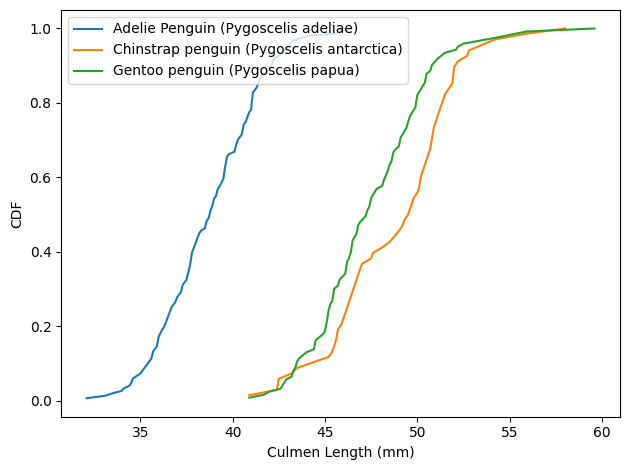

In [6]:
colname = 'Culmen Length (mm)'
plot_cdfs(df, colname)

이는 부리 상부 길이(Culmen Length) 분포다.  이 그래프를 보면, 부리 상부 길이를 사용해서 아델리 펭귄을 구분하는 것은 가능할 것 같지만 Chinstrap 펭귄과 Gentoo 펭귄의 분포는 거의 겹친다.

다음은 발 길이 분포다.

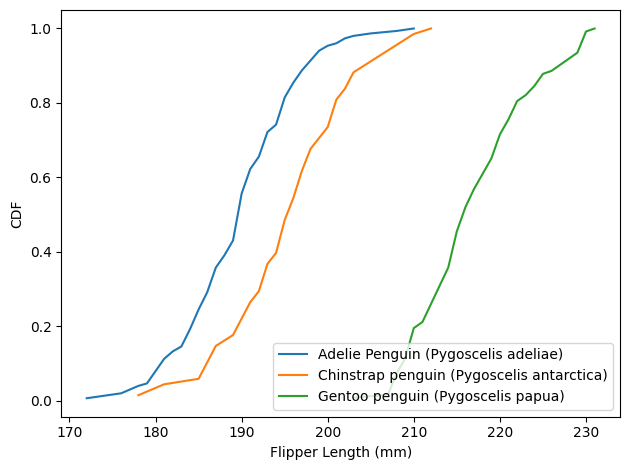

In [7]:
colname = 'Flipper Length (mm)'
plot_cdfs(df, colname)

발길이로 젠투 펭귄과 다른 두 종을 구분할 수 있다. 이 두 가지 값을 사용해서 어느 정도 정확하게 펭귄을 구분할 수 있다. 

모든 CDF가 정규분포의 특징인 sigmoid 형태를 보인다. 이런 형태에는 장점이 있는데, 이는 다음 절에서 사용하도록 하자.

## 12.2 정규 모델

앞서 살펴본 값들을 사용해서 펭귄을 분류해보자. 다음과 같은 일반적인 베이지안 방식으로 진행한다. 

1. 세 가능한 종에 대한 사전분포와 각 종에 대한 사전확률을 정의한다.
2. 각 종에 대한 가설에 대해 데이터의 가능도를 구한다.
3. 그 후 각 가설에 대한 사후분포를 구한다.

각 가설 하에서의 데이터의 가능도를 구하기 위해 이 데이터를 사용해서 각 종에 대한 정규분포의 매개변수를 측정해보자. 

다음 함수에서는 데이터프레임의 열의 이름을 사용해서 각 종의 이름과 norm 객체를 연결한 딕셔너리를 반환한다.

norm 은 scipy에 정의되어 있어, 이 객체는 주어진 평균과 표준편차에 대한 정규분포를 나타낸다. (= 매개변수는 평균, 표준편차다.)

In [8]:
from scipy.stats import norm

def make_norm_map(df:pd.DataFrame, colname:str, by = 'Species'):
    """Make a map from species to norm object."""
    norm_map = {}
    grouped = df.groupby(by)[colname]
    for species, group in grouped:  # species = by, group = [colname]
        mean = group.mean()
        std = group.std()
        norm_map[species] = norm(mean, std)
    return norm_map

예를 들어, 발 길이에 대한 norm 객체의 딕셔너리를 다음과 같이 규정했다.

In [9]:
flipper_map = make_norm_map(df,'Flipper Length (mm)')

In [10]:
flipper_map.keys()

dict_keys(['Adelie Penguin (Pygoscelis adeliae)', 'Chinstrap penguin (Pygoscelis antarctica)', 'Gentoo penguin (Pygoscelis papua)'])

그럼 펭귄의 신체를 측정해서 발길이가 193mm임을 알았다고 하자. 그럼 각 가설 하에서 이 측정치가 맞을 확률은 얼마인가?

norm 객체는 확률밀도함수를 구하는 pdf()를 제공한다. 이 함수를 사용해서 주어진 분포에서 관측 데이터의 가능도를 구한다. 

In [11]:
flipper_map['Adelie Penguin (Pygoscelis adeliae)'].pdf(193)

0.054732511875530694

결과는 확률 밀도로 나오므로, 이 값을 확률로 해석하면 안 된다. 하지만 이는 데이터의 가능도에 따른 비율이므로 이 값을 사용해서 사전분포를 갱신할 수 있다.

다음은 각 분포에서 데이터의 가능도를 구하는 방법이다. 

In [12]:
hypos = flipper_map.keys()
data = 193
likelihood = [flipper_map[hypo].pdf(data) for hypo in hypos]
likelihood

[0.054732511875530694, 0.05172135615888162, 5.8660453661990634e-05]

그럼 갱신할 준비가 끝났다. 

## 12.3 갱신

앞서 해왔던 것처럼 Pmf 를 사용해서 사전분포를 나타낼 것이다. 간단히 하기 위해, 세 종이 발견될 가능성은 동일하다고 가정한다(uniform).

그럼 앞선 방법들과 같이 갱신을 해보자.

In [13]:
prior = Pmf(1, hypos)
prior.normalize()
prior

,probs
Adelie Penguin (Pygoscelis adeliae),0.333333
Chinstrap penguin (Pygoscelis antarctica),0.333333
Gentoo penguin (Pygoscelis papua),0.333333


In [14]:
posterior = prior * likelihood
posterior.normalize()
posterior

,probs
Adelie Penguin (Pygoscelis adeliae),0.513860
Chinstrap penguin (Pygoscelis antarctica),0.485589
Gentoo penguin (Pygoscelis papua),0.000551


발길이가 193mm 인 펭귄이 젠투일 가능성은 거의 없지만, 아델리인지 Chinstrap 인지 알 수가 없다. (측정 전에는 세 종 중 각 종일 가능성은 동일하다고 가정한다.)

다음 함수는 앞서서 실행했던 과정들을 묶었다. 사전분포를 나타내는 Pmf와 관측 데이터, 각 가설과 특성의 분포를 엮은 dictionary를 사용한다.

In [15]:
def update_penguin(prior:Pmf, data: int, norm_map:dict)->Pmf:
    """update hypothetical species."""
    hypos = prior.qs
    likelihood = [norm_map[hypo].pdf(data) for hypo in hypos]
    posterior = prior * likelihood
    posterior.normalize()
    return posterior

결괏값은 사후확률분포다.

update_penguin()을 사용해서 이전 예제를 다시 실행해보자. 

In [16]:
posterior1 = update_penguin(prior = Pmf(1/3, hypos), data = 193, norm_map = flipper_map)
posterior1

,probs
Adelie Penguin (Pygoscelis adeliae),0.513860
Chinstrap penguin (Pygoscelis antarctica),0.485589
Gentoo penguin (Pygoscelis papua),0.000551


Cdf Plot 에서 봤던 것처럼, 아델리 펭귄과 Chinstrap 펭귄은 발 길이로는 뚜렷이 구분되지 않는다. 

하지만 부리 상단 길이 Culmen Length 를 통해 구분할 수 있으므로 분류 2회전으로 들어간다. 우선 다음과 같이 각 종의 부리 상단 길이의 분포를 추가한다.

In [17]:
culmen_map = make_norm_map(df, 'Culmen Length (mm)')

이번에는 부리 길이가 48mm 인 펭귄을 봤다고 해보자. 이 데이터를 사용해서 다음과 같이 사전분포를 업데이트할 수 있다. 

In [18]:
posterior2 = update_penguin(prior = Pmf(1/3, hypos), data = 48, norm_map = culmen_map)
posterior2

,probs
Adelie Penguin (Pygoscelis adeliae),0.001557
Chinstrap penguin (Pygoscelis antarctica),0.474658
Gentoo penguin (Pygoscelis papua),0.523785


부리 상단 길이가 48mm 인 펭귄은 높은 확률로 Chinstrap 이거나 Gentoo 펭귄이다. 한 번에 하나의 특징을 사용하면 한 종을 후보에서 제외하는 것은 가능하지만, 완전히 정답을 골라내기는 쉽지 않다.

여러 특징을 사용하면 나아질 것이다.

## 12.4 나이브 베이지안 분류

다음 함수를 사용해서 여러 번의 갱신을 더 쉽게 할 것이다. 이 함수에서는 사전 Pmf, 측정값의 순열과 이 값에 대응하는 추정 분포를 포함하는 dictionary sequence를 입력값으로 사용한다.

In [19]:
def update_naive(prior:Pmf, data_seq: list, norm_maps: list)->Pmf:
    """Naive Bayesian Classification. 
    prior: Prior Pmf,
    data_seq: data sequence,
    norm_maps: species-norm dictionary sequence
    return: posterior Pmf
    """
    posterior = prior.copy()
    for data, norm_map in zip(data_seq, norm_maps):
        posterior = update_penguin(posterior, data, norm_map) # 차례로 사후분포를 업데이트
    return posterior

이 함수는 한 번에 한 변수씩 갱신을 연속적으로 수행해서 사후 Pmf를 반환한다. 확인차, 앞 절에서 살펴본 것과 동일한 특징을 사용해서 실행해보도록 하자.

In [20]:
colnames = ['Flipper Length (mm)', 'Culmen Length (mm)']
norm_maps = [flipper_map, culmen_map]
data_seq = 193, 48
posterior = update_naive(prior, data_seq, norm_maps)
posterior

,probs
Adelie Penguin (Pygoscelis adeliae),0.003455
Chinstrap penguin (Pygoscelis antarctica),0.995299
Gentoo penguin (Pygoscelis papua),0.001246


In [21]:
posterior.idxmax()

'Chinstrap penguin (Pygoscelis antarctica)'

이 펭귄은 거의 확실히 턱끈 펭귄으로 추정된다. 

반복문에 데이터셋을 넣어서 두 특징을 사용해 여러 펭귄을 분류할 수 있다. 

In [22]:
import numpy as np

df['Classification'] = np.nan

for i, row in df.iterrows():
    data_seq = row[colnames]
    posterior = update_naive(prior, data_seq, norm_maps)
    df.loc[i, 'Classification'] = posterior.max_prob() 

/tmp/ipykernel_13141/2486766405.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Adelie Penguin (Pygoscelis adeliae)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[i, 'Classification'] = posterior.max_prob()
/home/user/anaconda3/envs/bayes/lib/python3.9/site-packages/empiricaldist/empiricaldist.py:479: FutureWarning: The behavior of Pmf.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  return self.idxmax(**kwargs)
/home/user/anaconda3/envs/bayes/lib/python3.9/site-packages/empiricaldist/empiricaldist.py:479: FutureWarning: The behavior of Pmf.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  return self.idxmax(**kwargs)


데이터프레임에 Classification 을 추가한 후 데이터프레임의 값을 반복문으로 업데이트했다. 이 열에는 각 펭귄별로 최대 사후 확률을 가지는 종 이름을 기록한다. 

얼마나 정확한 결과가 나오나 확인해보자. 

In [23]:
df['Classification'].head()

0    Adelie Penguin (Pygoscelis adeliae)
1    Adelie Penguin (Pygoscelis adeliae)
2    Adelie Penguin (Pygoscelis adeliae)
3                                    NaN
4    Adelie Penguin (Pygoscelis adeliae)
Name: Classification, dtype: object

In [24]:
df['Classification'].value_counts()

Classification
Adelie Penguin (Pygoscelis adeliae)          148
Gentoo penguin (Pygoscelis papua)            128
Chinstrap penguin (Pygoscelis antarctica)     66
Name: count, dtype: int64

In [25]:
valid = df['Classification'].notna()
valid.sum()

342

In [26]:
same = df['Species'] == df['Classification']
same.sum()

324

데이터셋에 있는 펭귄 수는 344마리지만, 2 마리는 측정값이 결여되어 있어 유효한 개체는 342마리였다. 

이 중에서 맞게 분류된 펭귄은 324마리로 이는 대략 전체의 95% 정도다. 

In [27]:
same.sum()/valid.sum()

0.9473684210526315

In [28]:
def accuracy(df):
    valid = df['Classification'].notna()
    same = df['Species'] == df['Classification']
    return same.sum()/valid.sum()

이 장에서는 사용한 분류기의 경우 특징 간의 연관성을 고려하지 않으므로 나이브라고 부른다. 

이게 왜 중요한 지를 확인하기 위해 특징의 결합분포도 사용하는 덜 나이브한 분류기를 만들어보자. 


## 12.5 결합분포(joint distribution)

일단 데이터의 산점도를 만들어 보자. 

In [29]:
import matplotlib.pyplot as plt

def scatterplot(df, var1, var2):
    grouped = df.groupby('Species')
    for species, group in grouped:
        plt.scatter(group[var1], group[var2], label = species, lw = 0.1, alpha = 0.3)
    decorate(xlabel = var1, ylabel = var2)

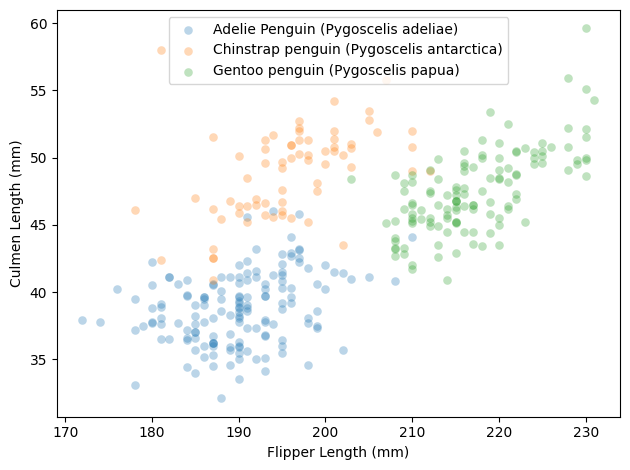

In [30]:
var1 = 'Flipper Length (mm)'
var2 = 'Culmen Length (mm)'
scatterplot(df, var1, var2)

각 종 간의 측정치에 대한 결합분포는 대략 타원 형태로 나타난다. 타원의 방향은 그래프의 대각선 쪽으로, 이는 부리 상부 길이와 발 길이간 상관관계가 있음을 암시한다.

만약 이 상관관계를 무시한다면 각 특징은 독립적이라고 가정할 수 있다. 이 경우 어떻게 되는지 살펴보자. 

각 특징 간 독립적이라고 가정하고 각 종의 결합분포를 만들어 보겠다. 

다음 함수는 정규분포에 근사하는 이산 Pmf를 만든다. 

In [31]:
def make_pmf_norm(dist, sigmas = 3, n = 101):
    """정규분포에 근사하는 Pmf를 생성함"""
    mean, std = dist.mean(), dist.std()
    low = mean - sigmas * std
    high = mean + sigmas * std
    qs = np.linspace(low, high, n)
    ps = dist.pdf(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

이 함수와 make_joint()을 사용해서 각 종의 부리 상부 길이와 발 길이의 결합분포를 만든다. 

In [32]:
def make_joint(s1, s2):
    """Compute the outer product of two Series.

    First Series goes across the columns;
    second goes down the rows.

    s1: Series
    s2: Series

    return: DataFrame
    """
    X, Y = np.meshgrid(s1, s2)
    return pd.DataFrame(X*Y, columns=s1.index, index=s2.index)

In [33]:
hypos

dict_keys(['Adelie Penguin (Pygoscelis adeliae)', 'Chinstrap penguin (Pygoscelis antarctica)', 'Gentoo penguin (Pygoscelis papua)'])

In [34]:
joint_map = {}
for species in hypos:
    pmf1 = make_pmf_norm(flipper_map[species])
    pmf2 = make_pmf_norm(culmen_map[species])
    joint_map[species] = make_joint(pmf1, pmf2)

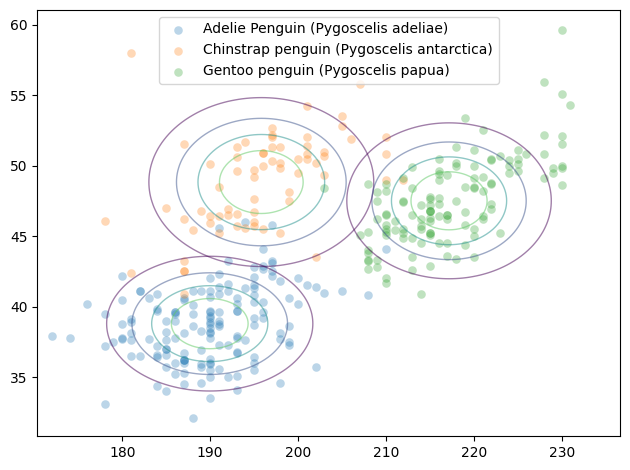

In [35]:
from utils import plot_contour

scatterplot(df, var1,var2)
for species in hypos:
    plot_contour(joint_map[species], alpha = 0.5)

결합 정규분포의 경계선은 타원형을 띈다. 이 예제에서는 특징간 연관성이 없다고 가정했기 때문에 타원이 축에 평평하게 배치되었다. 

하지만 데이터의 분포와 그다지 잘 맞지 않는 듯하다. 

다변량 정규분포를 사용하면 데이터를 더 나은 모델링을 통해 가능도를 더 잘 구할 수 있다.


## 12.6 다변량 정규분포(Multivariate Normal Distribution)

앞서 살펴본 것처럼 일변량 정규분포는 평균과 표준편차로 정의할 수 있다.

다변량 정규분포는 특징값의 평균과 각 특징의 값이 얼마나 퍼져 있는지를 숫자로 나타낸 값인 'Variance(분산)' 과 특징간 관계를 숫자로 나타낸 'Covariance(공분산)'이 들어있는 공분산행렬로 정의한다. 

데이터를 사용해서 펭귄에 대한 평균과 공분산행렬을 추정할 수 있다. 우선 필요한 열을 선택한다.

In [36]:
features = df[[var1, var2]]
_mean = features.mean()
_mean

Flipper Length (mm)    200.915205
Culmen Length (mm)      43.921930
dtype: float64

다음과 같이 공분산행렬도 구한다. 

In [37]:
_cov = features.cov()
_cov


,Flipper Length (mm),Culmen Length (mm)
Flipper Length (mm),197.731792,50.375765
Culmen Length (mm),50.375765,29.807054


결과는 각 특징별로 한 행과 한 열을 갖는 데이터프레임이다. 행렬의 대각성분의 값은 분산이고, 대각성분 외의 값은 공분산이다. 

분산과 공분산은 이 값만으로 해석하기 힘들다. 이 값으로 표준편차와 상관계수를 구하면 해석하기 더 쉽겠지만, 이 계산에 대해 자세히 이해하는 것은 당장 필요하지는 않다.

대신 다변량 정규분포를 나타내는 객체를 생성하는 scipy 함수 multivariate_normal()에 이 공분산행렬을 넣어보자. 

이 함수는 평균의 순열과 공분산행렬을 취한다. 

In [38]:
from scipy.stats import multivariate_normal

multi_norm = multivariate_normal(mean = _mean, cov = _cov)

다음 함수는 각 종별로 multivariate_normal 객체를 만든다.

In [39]:
def make_multinorm_map(df,colnames):
    multinorm_map = {}
    grouped = df.groupby('Species')
    for species, group in grouped:
        features = group[colnames]
        mean = features.mean()
        cov = features.cov()
        multinorm_map[species] = multivariate_normal(mean, cov)
    return multinorm_map

다음은 발 길이와 부리 상단 길이의 두 특징에 대한 이 객체를 만드는 코드다. 

In [40]:
multinorm_map = make_multinorm_map(df, [var1, var2])

## 12.8 요약

이 장에서는 분류에 사용하는 특징들이 독립적이라고 가정한다는 측면에서 나이브한 나이브 베이지안 분류기를 구현했다.

이 가정이 얼마나 안 좋은지 살펴보기 위해, 다변량 정규분포를 사용해서 특징간 의존성을 고려한 결합분포를 모델링한 분류기도 만들었다.

이 사례에서 나이브하지 않은 분류기가 아주 조금 더 나았다. 어떻게 보면 실망스럽다. 최종적으로 성능이 훨씬 나았어야 만족스러웠을 것이다. 

일반적으로 나이브 베이지안 분류기는 구현하기 쉽고 연산을 덜 한다. 

이런 알고리즘이 훨씬 복잡한 알고리즘과 성능이 비슷하다면, 실제로 사용할 때는 이 알고리즘을 고르는 게 유용하다.

사실 이 장에서 다룬 예제는 그다지 실용적이지 않다. 펭귄의 종을 구별할 때는 발과 부리의 길이를 재는 것보다 더 쉬운 방법이 있다.

하지만 이런 분류 방식은 과학적으로 여러 방면에서 활용된다. 살펴볼 만한 과학 논문 중 하나로는 같은 동물의 암수간 나타나는 신체적 차이인 성적 이형에 대한 것이다. 

아구 같은 종은 암수가 매우 다르게 생겼다. 앵무새 같은 종은 암수 구분이 어렵다. 성적 이형에 대해 연구하면서 동물의 사회적 행동, 성, 선택, 진화에 대해 더 많이 이해할 수 있게 된다. 

특정 종의 성적 이형 정도를 계량하는 한 가지 방법은 이 장에서 사용한 것과 같은 분류 알고리즘을 사용하는 것이다. 

높은 정확도로 각 개체의 성별을 구분할 수 있는 특징을 발견한다면 이는 성적 이형이 높다는 증거가 될 수 있다.

연습 문제에서는 이 장에서 사용한 데이터셋으로 펭귄의 성별을 구분하고 세 종 중 어떤 종이 가장 성적 이형 정도가 높은 지를 알아보자. 

## 12.9 연습문제

### 문제 12.1

본문의 예시에서 culmen length와 flipper length를 사용한 이유는 이 특징이 세 종을 가장 잘 구분하는 것 같았기 때문이다. 

하지만 더 많은 특징들을 사용하면 더 높은 성능이 나올 지도 모른다. 

데이터셋에 있는 부리 상단 길이, 부리 상단 폭, 발 길이, 체중을 모두 사용하는 나이브 베이지안 분류기를 만들자. 이 분류기가 두 특징만 사용했을 때보다 정확도가 더 높은가?

In [41]:
df.columns

Index(['studyName', 'Sample Number', 'Species', 'Region', 'Island', 'Stage',
       'Individual ID', 'Clutch Completion', 'Date Egg', 'Culmen Length (mm)',
       'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)', 'Sex',
       'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)', 'Comments', 'Classification'],
      dtype='object')

In [45]:
df['Culmen Depth (mm)'].unique()

array([18.7, 17.4, 18. ,  nan, 19.3, 20.6, 17.8, 19.6, 18.1, 20.2, 17.1,
       17.3, 17.6, 21.2, 21.1, 19. , 20.7, 18.4, 21.5, 18.3, 19.2, 17.2,
       18.9, 18.6, 17.9, 16.7, 17. , 20. , 18.5, 19.1, 19.7, 16.9, 18.8,
       17.7, 19.5, 17.5, 16.6, 18.2, 16.2, 19.4, 16.8, 16.1, 20.3, 16. ,
       16.5, 20.5, 19.8, 15.9, 20.1, 15.5, 13.2, 16.3, 14.1, 15.2, 14.5,
       13.5, 14.6, 15.3, 13.4, 15.4, 13.7, 15.7, 15.1, 14.3, 15.8, 13.1,
       15. , 14.2, 14.8, 13.6, 13.9, 13.3, 14.4, 13.8, 14.9, 15.6, 16.4,
       14. , 14.7, 19.9, 20.8])

In [46]:
df['Body Mass (g)'].unique()

array([3750., 3800., 3250.,   nan, 3450., 3650., 3625., 4675., 3475.,
       4250., 3300., 3700., 3200., 4400., 4500., 3325., 4200., 3400.,
       3600., 3950., 3550., 3150., 3900., 4150., 4650., 3100., 3000.,
       4600., 3425., 2975., 3500., 4300., 4050., 2900., 2850., 3350.,
       4100., 3050., 4450., 4000., 4700., 4350., 3725., 4725., 3075.,
       2925., 3175., 4775., 3825., 4275., 4075., 3775., 3875., 3275.,
       4475., 3975., 5700., 5400., 4550., 4800., 5200., 5150., 5550.,
       5850., 6300., 5350., 5000., 5050., 5100., 5650., 5250., 6050.,
       4950., 4750., 4900., 5300., 4850., 5800., 6000., 5950., 4625.,
       5450., 5600., 4875., 4925., 4975., 5500., 4575., 4375., 5750.,
       3525., 3575., 3850., 2700., 3675.])

In [42]:
# 나이브 베이즈

colnames4 = ['Culmen Length (mm)','Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)']

depth_map = make_norm_map(df, 'Culmen Depth (mm)')
mass_map = make_norm_map(df, 'Body Mass (g)')
norm_maps4 = [culmen_map, flipper_map, depth_map, mass_map]

df['Classification'] = 'None'
for i, row in df.iterrows():
    data_seq = row[colnames4]
    posterior = update_naive(prior, data_seq, norm_maps4)
    df.loc[i, 'Classification'] = posterior.max_prob()

/home/user/anaconda3/envs/bayes/lib/python3.9/site-packages/empiricaldist/empiricaldist.py:479: FutureWarning: The behavior of Pmf.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  return self.idxmax(**kwargs)
/home/user/anaconda3/envs/bayes/lib/python3.9/site-packages/empiricaldist/empiricaldist.py:479: FutureWarning: The behavior of Pmf.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  return self.idxmax(**kwargs)
/home/user/anaconda3/envs/bayes/lib/python3.9/site-packages/empiricaldist/empiricaldist.py:479: FutureWarning: The behavior of Pmf.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  return self.idxmax(**kwargs)
/home/user/anaconda3/envs/bayes/lib/python3.9/site-packages/empiricaldist/empiricaldist.py:479: FutureWarning: The behavior of Pmf.idxmax with all-NA values, or an

In [43]:
accuracy(df)

/tmp/ipykernel_13141/2595680106.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return same.sum()/valid.sum()


nan